In [1]:
!pip freeze > requirements.txt

In [3]:
import tensorflow as tf


print(tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", len(gpus))

True
Available GPUs:  1


In [16]:
import os
from collections import Counter

import numpy as np
import pandas as pd

from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

import joblib


In [5]:
data_path = 'G:\\HSUHK\\COM6003\\app\\archive'

In [6]:
class TextPreprocessor:
    def __init__(self, data):
        self.data = pd.DataFrame(data)
        self.x_train = None
        self.x_test = None
        self.x_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        
    def clean_text(self):
        self.data.drop(columns=['patient_id', 'lesion_id', 'biopsed'], inplace=True)
        self.data['label'] = self.data['diagnostic']
        self.data.drop(columns='diagnostic', inplace=True)
        self.data.replace({'UNK':-1, 'NaN':-1, np.nan:-1, 'FALSE': 'False', 'TRUE': 'True'}, inplace=True)

    def encode_text(self):
        binary_column_name = ['smoke', 'drink', 'pesticide', 'gender', 'skin_cancer_history', 
                              'cancer_history', 'has_piped_water', 'has_sewage_system', 
                              'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']
        self.convert_to_binary(binary_column_name)
        self.convert_to_integer('background_father', {'AUSTRIA':0, 'BRASIL':1, 'BRAZIL':2, 'CZECH':3,
                                                             'GERMANY':4, 'ISRAEL':5, 'ITALY':6, 'NETHERLANDS':7,
                                                                'POLAND':8, 'POMERANIA':9, 'PORTUGAL':10, 'SPAIN':11})
        self.convert_to_integer('background_mother', {'BRAZIL':0, 'FRANCE':1, 'GERMANY':2, 'ITALY':3,
                                                                'NETHERLANDS':4, 'NORWAY':5, 'POLAND':6, 'POMERANIA':7,
                                                                'PORTUGAL':8, 'SPAIN':9})
        self.convert_to_integer('region', {'ABDOMEN':0, 'ARM':1, 'BACK':2, 'CHEST':3, 
                                                                     'EAR':4, 'FACE':5, 'FOOT':6, 'FOREARM':7, 
                                                                     'HAND':8, 'LIP':9, 'NECK':10, 'NOSE':11, 
                                                                     'SCALP':12, 'THIGH':13})
        self.convert_to_integer('label', {'ACK':0, 'BCC':1, 'MEL':2, 'NEV':3, 'SCC':4, 'SEK':5})
    
    def convert_to_binary(self, column_name):
        for i in column_name:
            if i =='gender':
                self.data[i] = self.data[i].replace({'FEMALE':0, 'MALE':1}).astype(int)
            else:
                self.data[i] = self.data[i].replace({'False': 0, 'True': 1}).astype(int)

    def convert_to_integer(self, column_name, mapping):
        self.data[column_name] = self.data[column_name].replace(mapping).astype(int)


    def text_preprocess(self):
        self.clean_text()
        self.encode_text()
        self.convert_image_path()
        self.split_data()
        self.balance_data()
        return self.x_train, self.x_val, self.x_test, self.y_train, self.y_val, self.y_test, self.data
    
    def get_image_path(self):
        image_path = []
        for root, dirs, files in os.walk(data_path):
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    image_path.append(os.path.abspath(file_path))
        return image_path
    
    def convert_image_path(self):
        pattern = {}
        for path in self.get_image_path():
            if os.path.basename(path) in self.data['img_id'].values:
                pattern[os.path.basename(path)] = path
        self.data['img_id'] = self.data['img_id'].replace(pattern)

    def balance_data(self, balance_factor=2):
        labels = self.y_train.values
        class_count = Counter(labels)
        min_class_count = min(class_count.values())
        over_sample_strategy = {label: min_class_count*balance_factor for label in class_count.keys() if class_count[label] <= (min_class_count*balance_factor)}
        under_sample_strategy = {label: min_class_count*balance_factor for label in class_count.keys() if class_count[label] > (min_class_count*balance_factor)}
        pipe = make_pipeline(
            RandomOverSampler(sampling_strategy=over_sample_strategy),
            RandomUnderSampler(sampling_strategy=under_sample_strategy)
        )
        self.x_train, self.y_train = pipe.fit_resample(self.x_train, self.y_train)

        return self.x_train, self.y_train
    
    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data.drop(columns='label'),self.data['label'], test_size=0.2, random_state=42)
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)
        
        


In [7]:
df = pd.read_csv(data_path+'\\metadata.csv')
x_train, x_val, x_test, y_train, y_val, y_test, df = TextPreprocessor(df).text_preprocess()

# Image Data

In [8]:
class DataGenerator:
    def __init__(self, x, y, batch_size=32, img_size=(256, 256), channels=3, num_classes=6):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.num_classes = num_classes

    def img_preprocessing(self, img, label):
        if self.img_size == (224, 224):
            img = tf.io.read_file(img)
            img = tf.image.decode_png(img, channels=self.channels)
            img = tf.image.resize(img, (224, 224))
            img = tf.cast(img, tf.float32) / 223
            if self.num_classes == 2:
                pass
            else:
                label = tf.one_hot(label, depth=self.num_classes)
            return img, label
        else:
            img = tf.io.read_file(img)
            img = tf.image.decode_png(img, channels=self.channels)
            img = tf.image.resize(img, self.img_size)
            img = tf.cast(img, tf.float32) / 255
            if self.num_classes == 2:
                pass
            else:
                label = tf.one_hot(label, depth=self.num_classes)
        return img, label

    def augmentation(self, image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return image, label

    def create_dataset(self, augment=False):
        loader = tf.data.Dataset.from_tensor_slices((self.x['img_id'], self.y))
        if augment:
            dataset = (loader.map(self.img_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Apply image preprocessing function)
                            .map(self.augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Apply data augmentation function
                            .batch(self.batch_size)  # Batch the data
                            .shuffle(self.batch_size * 10)  # Shuffle the dataset
                            .prefetch(tf.data.experimental.AUTOTUNE).repeat())  # Prefetch data for performance
        else:
            dataset = (loader.map(self.img_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .batch(self.batch_size) # Batch the data
                            .prefetch(tf.data.experimental.AUTOTUNE)) # Prefetch data for performance
            
        return dataset

In [72]:
train_augment_dataset = DataGenerator(x_train, y_train).create_dataset(augment=True)
train_dataset = DataGenerator(x_train, y_train).create_dataset()
val_dataset = DataGenerator(x_val, y_val).create_dataset()
test_dataset = DataGenerator(x_test, y_test).create_dataset()
df_dataset = DataGenerator(df.drop(columns='label'), df['label']).create_dataset()

In [8]:
def show_images(dataset, class_mode, num_rows=2, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    # Iterate over the dataset
    for images, labels in dataset:
        # Get the true labels based on the class_mode
        if class_mode == 'categorical':
            true_labels = labels.numpy().squeeze()
        elif class_mode == 'binary':
            true_labels = labels.numpy().flatten()
        else:
            raise ValueError(f"Invalid class_mode: {class_mode}")
        # Iterate over each image and label in the batch
        for i, (image, label) in enumerate(zip(images, true_labels)):
            # Get the corresponding axis
            ax = axes[i]
            # Display the image
            ax.imshow(image.numpy())
            # Set the title of the subplot based on the class_mode
            if class_mode == 'categorical':
                true_label_index = np.argmax(label)
                ax.set_title(f"Label: {true_label_index}")
            elif class_mode == 'binary':
                ax.set_title(f"Label: {label}")
            # Remove the axis ticks
            ax.axis('off')
            # Break the loop after displaying the desired number of images
            if i + 1 == num_rows * num_cols:
                break
        # Adjust the spacing between subplots
        plt.tight_layout()
        # Display the plot
        plt.show()
        # Break the loop after displaying images from one batch
        break


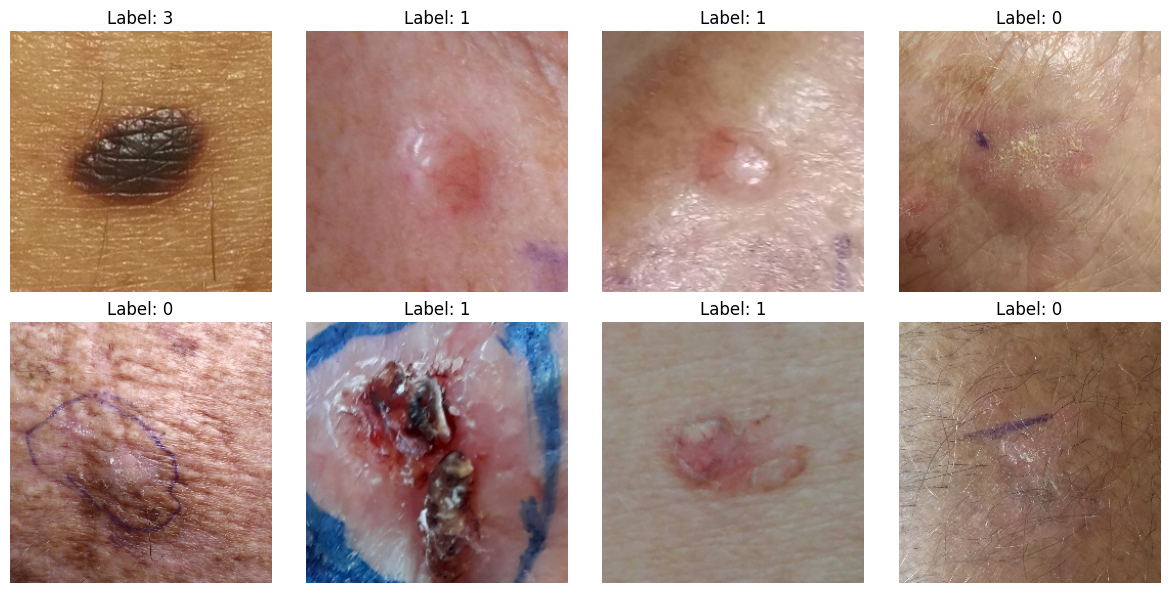

In [9]:
show_images(test_dataset, 'categorical')

# VGG16

## pretrained

In [17]:
def VGG16(num_classes=6):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3),name='conv1_1'))
    model.add(Conv2D(32, (3, 3), name='conv1_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2),name='pool1'))
    model.add(Conv2D(64, (3, 3), name='conv2_1'))
    model.add(Conv2D(64, (3, 3), name='conv2_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2),name='pool2'))
    model.add(Conv2D(128, (3, 3), name='conv3_1'))
    model.add(Conv2D(128, (3, 3), name='conv3_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2),name='pool3'))
    # model.add(Conv2D(64, (3, 3), name='conv4_1'))
    # model.add(Conv2D(64, (3, 3), name='conv4_2'))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D((2, 2), strides=(2, 2),name='pool4'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',name='fc1'))
    model.add(Dropout(0.5))
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid',name='fc2'))
    else:
        model.add(Dense(6, activation='softmax',name='fc2'))
    return model

## model

## set up

## Load Model

In [26]:
vgg16 = load_model('G:\\HSUHK\\COM6003\\app\\model\\VGG16Model6.h5')

In [32]:
predictions_vgg = vgg16.predict(df_dataset)
vgg_y_predict = np.argmax(predictions_vgg, axis=-1)
print(f"VGG16 Model: {classification_report(df['label'], vgg_y_predict, zero_division=0)}")

72/72 [==============================] - 6s 84ms/step
VGG16 Model:               precision    recall  f1-score   support

           0       0.53      0.42      0.47       730
           1       0.44      0.21      0.29       845
           2       0.17      0.38      0.23        52
           3       0.27      0.15      0.19       244
           4       0.12      0.42      0.18       192
           5       0.23      0.34      0.27       235

    accuracy                           0.31      2298
   macro avg       0.29      0.32      0.27      2298
weighted avg       0.39      0.31      0.32      2298



In [47]:
sixClass_df = df.copy()
predictions_vgg_df = pd.DataFrame(predictions_vgg, columns=['vgg_0', 'vgg_1', 'vgg_2', 'vgg_3', 'vgg_4', 'vgg_5'])
sixClass_df = pd.concat([sixClass_df, predictions_vgg_df], axis=1)
sixClass_df.drop(columns='img_id', inplace=True)


# stacking for six classes

In [54]:
svm = SVC(kernel='linear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
lgbm = LGBMClassifier(num_class=6, random_state=42, verbose=-1)


In [55]:
estimators_for_six = [('svc', svm), ('rf', rf), ('xgb', xgb), ('knn', knn), ('lgbm', lgbm)]
stack_model_for_six = StackingClassifier(estimators=estimators_for_six, final_estimator=XGBClassifier())

In [56]:
x_train_stack, x_test_stack, y_train_stack, y_test_stack = train_test_split(sixClass_df.drop(columns='label'), sixClass_df['label'], test_size=0.2, random_state=42)

In [57]:
# fit the model on the training data
stack_model_for_six.fit(x_train_stack, y_train_stack)
# make predictions
y_pred = stack_model_for_six.predict(x_test_stack)
# calculate the classification report
stack_model_for_six_result = classification_report(y_test_stack, y_pred)
print(f'Stack Model: {stack_model_for_six_result}')

Stack Model:               precision    recall  f1-score   support

           0       0.83      0.82      0.82       133
           1       0.77      0.90      0.83       177
           2       0.65      0.85      0.73        13
           3       0.89      0.68      0.77        50
           4       0.48      0.25      0.33        44
           5       0.67      0.65      0.66        43

    accuracy                           0.77       460
   macro avg       0.71      0.69      0.69       460
weighted avg       0.76      0.77      0.76       460



In [59]:
joblib.dump(stack_model_for_six,'stack_model_for_six.joblib')

['stack_model_for_six.joblib']

# two class

In [ ]:
# model_for_two = load_model('G:\\HSUHK\\COM6003\\app\\model\\VGG16Model_2.h5')

In [10]:
df['label'] = df['label'].replace({0:0, 1:1, 2:1, 3:0, 4:1, 5:0})
y_train = y_train.replace({0:0, 1:1, 2:1, 3:0, 4:1, 5:0})
y_val = y_val.replace({0:0, 1:1, 2:1, 3:0, 4:1, 5:0})
y_test = y_test.replace({0:0, 1:1, 2:1, 3:0, 4:1, 5:0})

In [11]:
train_augment_dataset = DataGenerator(x_train, y_train, num_classes=2).create_dataset(augment=True)
train_dataset = DataGenerator(x_train, y_train, num_classes=2).create_dataset()
val_dataset = DataGenerator(x_val, y_val, num_classes=2).create_dataset()
test_dataset = DataGenerator(x_test, y_test, num_classes=2).create_dataset()
df_dataset = DataGenerator(df.drop(columns='label'), df['label'], num_classes=2).create_dataset()

In [24]:
model_for_two = load_model('G:\\HSUHK\\COM6003\\app\\model\\VGG16Model2.h5')

In [25]:
model_for_two.predict(df_dataset)

72/72 [==============================] - 7s 94ms/step


array([[0.36937988],
       [0.8160095 ],
       [0.8651669 ],
       ...,
       [0.40842268],
       [0.6908496 ],
       [0.26986903]], dtype=float32)

In [30]:
predictions_for_two = model_for_two.predict(df_dataset)
y_predict_for_two = np.where(predictions_for_two > 0.5, 1, 0)
print(f"Model for Two: {classification_report(df['label'], y_predict_for_two, zero_division=0)}")

72/72 [==============================] - 6s 84ms/step
Model for Two:               precision    recall  f1-score   support

           0       0.79      0.65      0.71      1209
           1       0.67      0.81      0.73      1089

    accuracy                           0.72      2298
   macro avg       0.73      0.73      0.72      2298
weighted avg       0.73      0.72      0.72      2298



In [31]:
twoClass_df = df.copy()
predictions_for_two_df = pd.DataFrame(predictions_for_two, columns=['probability'])
twoClass_df = pd.concat([twoClass_df, predictions_for_two_df], axis=1)
twoClass_df.drop(columns='img_id', inplace=True)


# stacking for two classes

In [41]:
svm = SVC(kernel='linear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
lgbm = LGBMClassifier(num_class=1, random_state=42, verbose=-1)

In [42]:
estimators_for_two = [('svc', svm), ('rf', rf), ('xgb', xgb), ('knn', knn), ('lgbm', lgbm)]
stack_model_for_two = StackingClassifier(estimators=estimators_for_two, final_estimator=LGBMClassifier(verbose=-1))

In [43]:
x_train_stack_for_two, x_test_stack_for_two, y_train_stack_for_two, y_test_stack_for_two = train_test_split(twoClass_df.drop(columns='label'), twoClass_df['label'], test_size=0.2, random_state=42)

In [44]:
stack_model_for_two.fit(x_train_stack_for_two, y_train_stack_for_two)
y_pred_stack_for_two = stack_model_for_two.predict(x_test_stack_for_two)

stack_model_for_two_result = classification_report(y_test_stack_for_two, y_pred_stack_for_two)
print(f'Stack Model: {stack_model_for_two_result}')

Stack Model:               precision    recall  f1-score   support

           0       0.93      0.90      0.91       226
           1       0.90      0.93      0.92       234

    accuracy                           0.92       460
   macro avg       0.92      0.91      0.92       460
weighted avg       0.92      0.92      0.92       460

